# Sentiment Analysis part

This notebook performs sentiment analysis on the cleaned reviews from the previous notebook (`data_collection.ipynb`).

# Setup



In [41]:
# where to save and read the data from
main_path = './'
sources_path = "./sources"

In [42]:
!pip install -q langdetect
!pip install -q vaderSentiment
!pip install -q --upgrade transformers
!pip install -q torch
!pip install -q protobuf
!pip install -q googletrans==4.0.0-rc1
!pip install -q matplotlib
!pip install -q seaborn
!pip install -q streamlit

import argparse

import pandas as pd
from langdetect import detect
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from googletrans import Translator

import matplotlib.pyplot as plt
import seaborn as sns

import os

# Sentiment Analysis

The sentiment analysis is done using the VADER sentiment analysis tool. The reviews are first translated to English if they are not already in English. The sentiment score is then calculated for each review. The final output is a CSV file with the original reviews, the detected language, and the sentiment score.

In [43]:
# define global variables
initial_datasets = []
processed_datasets = []

source_template = {'name': None, 'data': None, 'filename': None}

### Load the Data

The data from the sources within the `sources` directory are loaded. The name of the source is extracted from the filename.

In [44]:
# Load the data
sources = os.listdir(sources_path)
for source in sources:
    source_data = pd.read_csv(f"{sources_path}/{source}")
    source_template['name'] = source.split('_')[0]
    source_template['data'] = source_data
    source_template['filename'] = f"{source}.csv"
    initial_datasets.append(source_template.copy())

In [45]:
initial_datasets[0]['data'].head()

,review_id,restaurant_id,restaurant,text,date,language
0,L7xKNDP5FD4gZWx3WeWn-g,4OsDhJHURGqfw1_22Gslgg,La Terrazza,My wife and I had dinner here last night. Wow!...,2023-05-27 23:26:51,en
1,RU9YgRF4Y1dLEqBrBb3Tzg,4OsDhJHURGqfw1_22Gslgg,La Terrazza,One of the best fine dining restaurants we hav...,2023-08-24 13:48:40,en
2,eGALOV7J-EKBm1Zb8Og-NQ,4OsDhJHURGqfw1_22Gslgg,La Terrazza,What an amazing view fantastic food and atmosp...,2019-10-10 12:09:42,en
3,y8O3Lr-IlwfSfGJ2R3RqMw,O-PwNezcRXYyx2xiu9qVHQ,Bottega Rocchi,Great place great pizza food awesome staff. Q...,2019-05-09 02:56:11,en
4,jVoTw2tImPJmGajp_XJ7Fw,O-PwNezcRXYyx2xiu9qVHQ,Bottega Rocchi,Simply put delicious and inexpensive. Fast fri...,2019-09-22 03:02:50,en


In [46]:
initial_datasets[1]['data'].head()

,review_id,restaurant_id,restaurant,text,date,language
0,45775551,73093209,Restaurant Zo,"Being from out of town, its always worrisome t...",Dined 7 days ago,en
1,43409730,73093209,Restaurant Zo,"the restaurant Zo was close, and it was far aw...","Dined on August 16, 2024",en
2,39410757,73093209,Restaurant Zo,Amazing dinner with friends. Food was deliciou...,"Dined on August 2, 2024",en
3,32270298,73093209,Restaurant Zo,Dined on Thursday evening with group of 9 coll...,"Dined on April 18, 2024",en
4,44992094,73093209,Restaurant Zo,Great food and staff was very friendly. Fun p...,"Dined on April 5, 2024",en


### Define required methods

The following methods are used to detect the language of the reviews, translate them to English if needed, and calculate the sentiment score using `VADER`.

In [47]:
# Initialize tools
vader_analyzer = SentimentIntensityAnalyzer()
translator = Translator()

def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

def translate_to_english(text, lang):
    try:
        if lang == 'en':
            return text  # No translation needed
        translated = translator.translate(text, src=lang, dest='en')
        return translated.text
    except Exception as e:
        print(f"Error translating text: {text}. Error: {e}")
        return None

# Analyze sentiment using VADER
def analyze_sentiment(text):
    sentiment = vader_analyzer.polarity_scores(text)
    return sentiment['compound']

# Process the dataframe
def process_reviews(dataframe, source_name):
    if 'language' not in dataframe.columns or len(dataframe['language'].isnull()) > 0:
        dataframe['language'] = dataframe['text'].apply(detect_language)
    dataframe['translated_text'] = dataframe.apply(
        lambda row: translate_to_english(row['text'], row['language']), axis=1
    )
    dataframe['sentiment_score'] = dataframe['translated_text'].apply(analyze_sentiment)
    dataframe.drop(columns=['translated_text'], inplace=True)  # Remove translated_text from final output
    dataframe.to_csv(os.path.join(main_path, f"{source_name}_reviews_with_sentiment.csv"), index=False)
    return dataframe

### Perform Sentiment Analysis

The sentiment analysis is performed on the reviews from the provided sources (Yelp and OpenTable in our case).

The results are saved to CSV files.

In [48]:
for dataset in initial_datasets:
    if dataset['name'] in [source['name'] for source in processed_datasets]: # Skip already loaded datasets
        continue
    final_filename = f"{dataset['name']}_reviews_with_sentiment.csv"
    processed_data = process_reviews(dataset['data'], dataset['name']) if not os.path.exists(main_path + final_filename) else pd.read_csv(main_path + final_filename)
    
    source_template['name'] = dataset['name']
    source_template['data'] = processed_data
    source_template['filename'] = final_filename
    processed_datasets.append(source_template.copy())

print("Sentiment analysis complete")

Sentiment analysis complete


In [49]:
processed_datasets[0]['data'].head()

,review_id,restaurant_id,restaurant,text,date,language,sentiment_score
0,L7xKNDP5FD4gZWx3WeWn-g,4OsDhJHURGqfw1_22Gslgg,La Terrazza,My wife and I had dinner here last night. Wow!...,2023-05-27 23:26:51,en,0.8805
1,RU9YgRF4Y1dLEqBrBb3Tzg,4OsDhJHURGqfw1_22Gslgg,La Terrazza,One of the best fine dining restaurants we hav...,2023-08-24 13:48:40,en,0.9381
2,eGALOV7J-EKBm1Zb8Og-NQ,4OsDhJHURGqfw1_22Gslgg,La Terrazza,What an amazing view fantastic food and atmosp...,2019-10-10 12:09:42,en,0.9380
3,y8O3Lr-IlwfSfGJ2R3RqMw,O-PwNezcRXYyx2xiu9qVHQ,Bottega Rocchi,Great place great pizza food awesome staff. Q...,2019-05-09 02:56:11,en,0.9441
4,jVoTw2tImPJmGajp_XJ7Fw,O-PwNezcRXYyx2xiu9qVHQ,Bottega Rocchi,Simply put delicious and inexpensive. Fast fri...,2019-09-22 03:02:50,en,0.9117


In [50]:
processed_datasets[1]['data'].head()

,review_id,restaurant_id,restaurant,text,date,language,sentiment_score
0,45775551,73093209,Restaurant Zo,"Being from out of town, its always worrisome t...",Dined 7 days ago,en,0.5808
1,43409730,73093209,Restaurant Zo,"the restaurant Zo was close, and it was far aw...","Dined on August 16, 2024",en,-0.7700
2,39410757,73093209,Restaurant Zo,Amazing dinner with friends. Food was deliciou...,"Dined on August 2, 2024",en,0.8910
3,32270298,73093209,Restaurant Zo,Dined on Thursday evening with group of 9 coll...,"Dined on April 18, 2024",en,0.9134
4,44992094,73093209,Restaurant Zo,Great food and staff was very friendly. Fun p...,"Dined on April 5, 2024",en,0.9036


## Result visualization

The sentiment scores are visualized in the following ways:
1. Distribution
2. Density
3. Proportion of sentiment categories

### Prepare data for visualization

The sources are combined in a single DataFrame, so to easily compare the sentiment between the two sources, together or separately.

In [51]:
for source in processed_datasets:
    source['data']['source'] = source['name']

# Combine datasets
combined_reviews = pd.concat([source['data'] for source in processed_datasets], ignore_index=True)

# Categorize sentiment
def categorize_sentiment(score):
    if score > 0.5:
        return 'Positive'
    elif score < -0.5:
        return 'Negative'
    else:
        return 'Neutral'

combined_reviews['sentiment_category'] = combined_reviews['sentiment_score'].apply(categorize_sentiment)
combined_reviews.head()

,review_id,restaurant_id,restaurant,text,date,language,sentiment_score,source,sentiment_category
0,L7xKNDP5FD4gZWx3WeWn-g,4OsDhJHURGqfw1_22Gslgg,La Terrazza,My wife and I had dinner here last night. Wow!...,2023-05-27 23:26:51,en,0.8805,yelp,Positive
1,RU9YgRF4Y1dLEqBrBb3Tzg,4OsDhJHURGqfw1_22Gslgg,La Terrazza,One of the best fine dining restaurants we hav...,2023-08-24 13:48:40,en,0.9381,yelp,Positive
2,eGALOV7J-EKBm1Zb8Og-NQ,4OsDhJHURGqfw1_22Gslgg,La Terrazza,What an amazing view fantastic food and atmosp...,2019-10-10 12:09:42,en,0.9380,yelp,Positive
3,y8O3Lr-IlwfSfGJ2R3RqMw,O-PwNezcRXYyx2xiu9qVHQ,Bottega Rocchi,Great place great pizza food awesome staff. Q...,2019-05-09 02:56:11,en,0.9441,yelp,Positive
4,jVoTw2tImPJmGajp_XJ7Fw,O-PwNezcRXYyx2xiu9qVHQ,Bottega Rocchi,Simply put delicious and inexpensive. Fast fri...,2019-09-22 03:02:50,en,0.9117,yelp,Positive


### Distribution of Sentiment Scores

In order to illustrate the sentiment distribution of the two sources, histogram plots are used. The first plot provides a combined view of the sentiment scores for OpenTable and Yelp, while the subsequent plots separately show the sentiment distributions for each source, highlighting their individual characteristics.

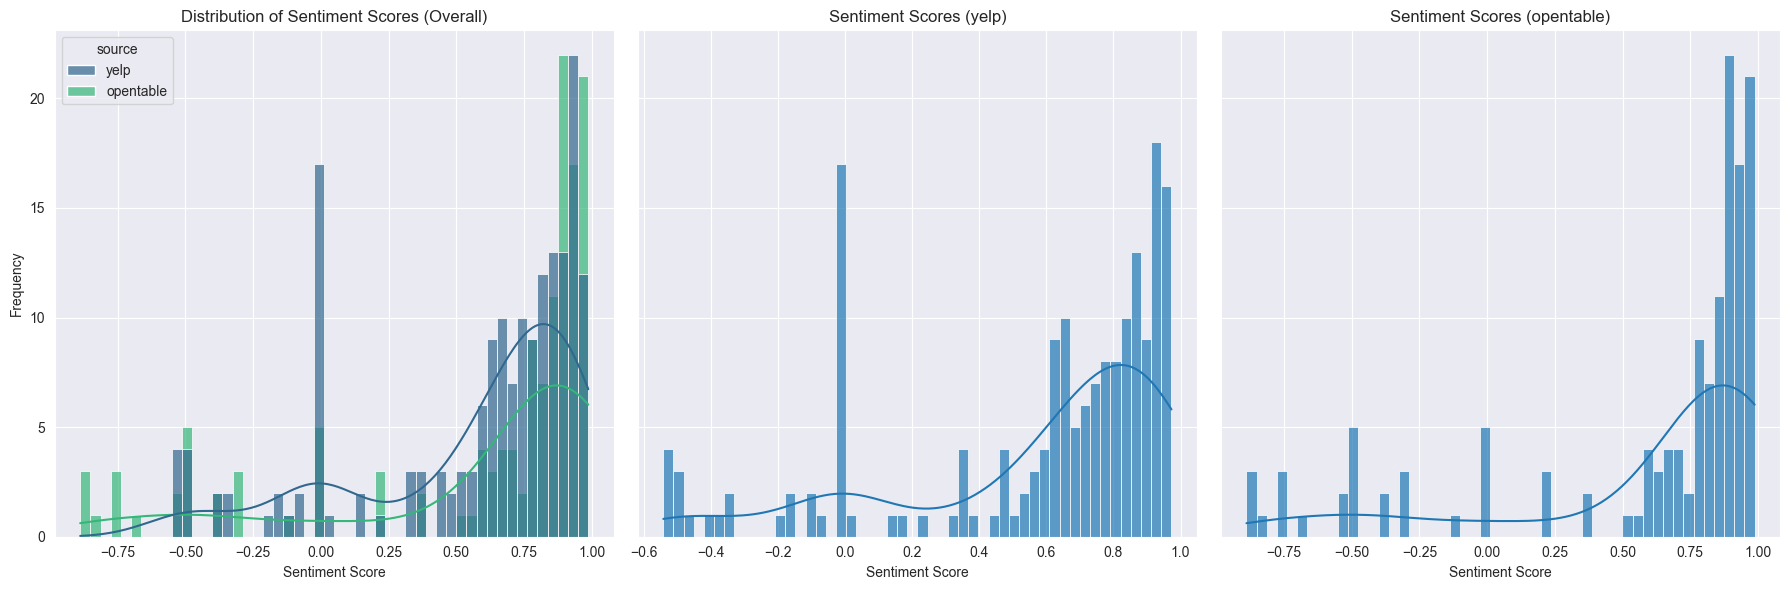

In [56]:
import math
num_of_sources = len(processed_datasets)
graph_per_row = 3
fig, axes = plt.subplots(math.ceil(num_of_sources / graph_per_row), graph_per_row, figsize=(18, 6), sharey=True)

# Distribution of Sentiment Scores
sns.histplot(
    data=combined_reviews,
    x='sentiment_score',
    hue='source',
    kde=True,
    bins=50,
    palette="viridis",
    alpha=0.7,
    ax=axes[0]
)
axes[0].set_title("Distribution of Sentiment Scores (Overall)")
axes[0].set_xlabel("Sentiment Score")
axes[0].set_ylabel("Frequency")
handles, labels = axes[0].get_legend_handles_labels()

# sources Sentiment Distribution
for i, source in enumerate(processed_datasets):
    sns.histplot(
        data=source['data'],
        x='sentiment_score',
        kde=True,
        bins=50,
        alpha=0.7,
        ax=axes[i + 1]
    )
    axes[i + 1].set_title(f"Sentiment Scores ({source['name']})")
    axes[i + 1].set_xlabel("Sentiment Score")
    axes[i + 1].set_ylabel("Frequency")
    axes[i + 1].legend([], [], frameon=False)

# Adjust layout
plt.tight_layout()
plt.show()

From these plots, we can observe that:
- The sentiment scores for both OpenTable and Yelp are skewed towards positive values, indicating that most reviews are generally favorable.
- Yelp reviews show a slightly more balanced distribution across the sentiment range, with a noticeable cluster near neutral (0 sentiment score) but also some negative reviews (scores near -0.5 or lower): there is a more significant spread of sentiment scores, including some negative reviews (scores near -0.5 or lower).
- The density and distribution differences suggest that Yelp may host a broader range of opinions (both positive and negative), possibly due to its diverse user base or review culture.
- OpenTable appears to have more consistently positive reviews, which might reflect a different target audience or user expectations.

### Density Plot of Sentiment Scores

To compare the sentiment variability and distribution across the two sources, violin and density plots are utilized. The violin plot illustrates the spread and variability of sentiment scores for each source, while the density plot provides a smooth, overlapping representation of sentiment score distributions, highlighting differences between OpenTable and Yelp.

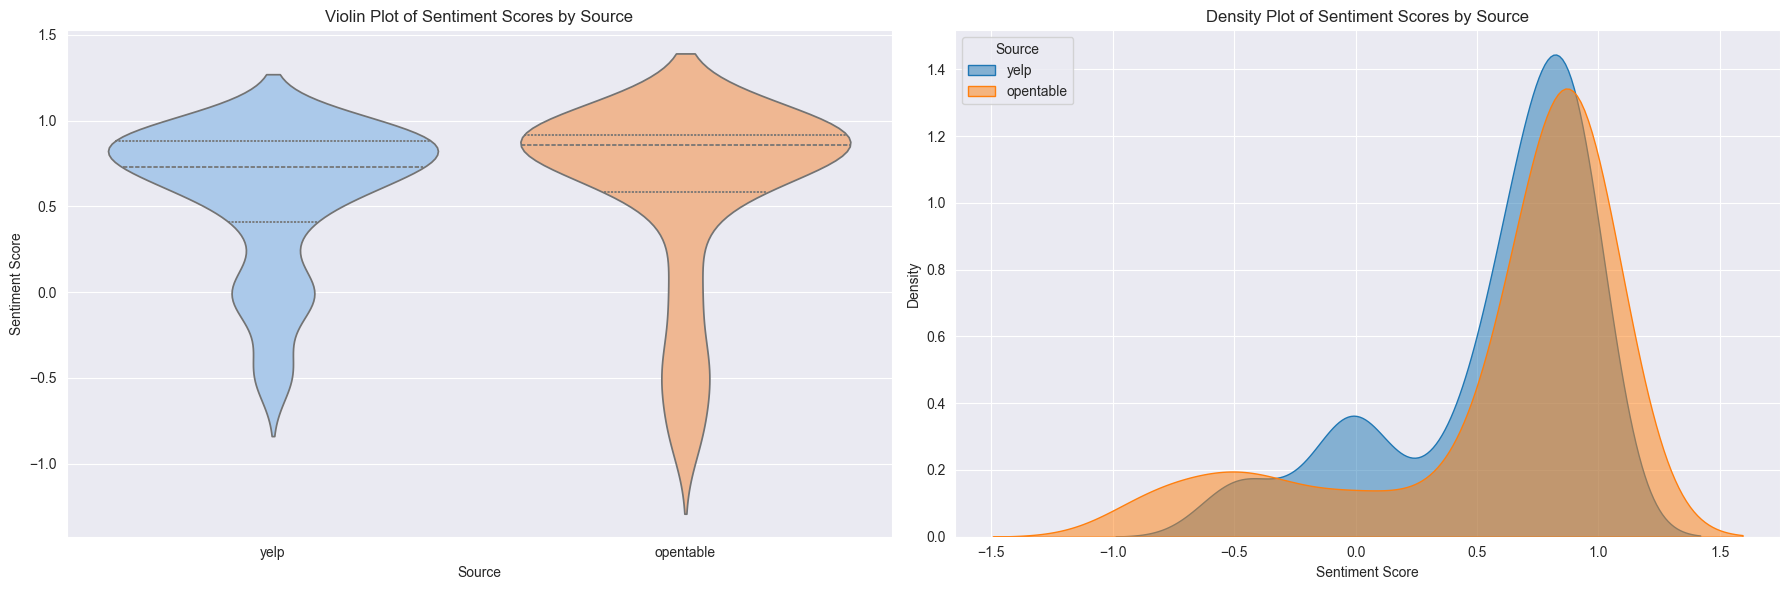

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

# Violin Plot of Sentiment Scores by Source
sns.violinplot(
    data=combined_reviews,
    x='source',
    y='sentiment_score',
    hue='source',
    inner="quartile",
    palette="pastel",
    ax=axes[0]
)
axes[0].set_title("Violin Plot of Sentiment Scores by Source")
axes[0].set_xlabel("Source")
axes[0].set_ylabel("Sentiment Score")
axes[0].legend([], [], frameon=False)

# Density Plot for Overlapping Sentiment Scores Between Sources
for source in processed_datasets:
    sns.kdeplot(
        data=source['data'],
        x='sentiment_score',
        fill=True,
        alpha=0.5,
        label=source['name'],
        ax=axes[1]
    )
axes[1].set_title("Density Plot of Sentiment Scores by Source")
axes[1].set_xlabel("Sentiment Score")
axes[1].set_ylabel("Density")
axes[1].legend(title="Source", loc="upper left")

plt.tight_layout()
plt.show()

The violin plot shows that OpenTable reviews (representing Paris) have a narrower sentiment range, mostly concentrated around positive scores. This suggests that Italian restaurants in Paris tend to receive consistently positive feedback from users, with fewer strongly negative or neutral reviews.

On the contrary, the sentiment distribution for Yelp reviews (representing Rome) is wider and includes more neutral and even negative reviews. This indicates that user sentiment for Italian restaurants in Rome is more varied, reflecting a mix of highly positive and less favorable experiences.

The density plot further supports these findings: OpenTable reviews peak sharply in the high-positive sentiment range (around 0.8–1.0), while Yelp reviews have a broader peak and a significant presence in the neutral-to-negative range. This suggests that Italian restaurants in Paris are consistently perceived as better or more satisfying compared to those in Rome, based on user feedback.

### Proportion of Sentiment Categories

To visualize the proportion of sentiment categories for the two sources, pie charts are used.

The sentiment scores are categorized into three categories: **Positive**, **Negative**, and **Neutral**. They are categories are defined as follows:
- **Positive**: Score > 0.5
- **Negative**: Score < -0.5
- **Neutral**: -0.5 <= Score <= 0.5

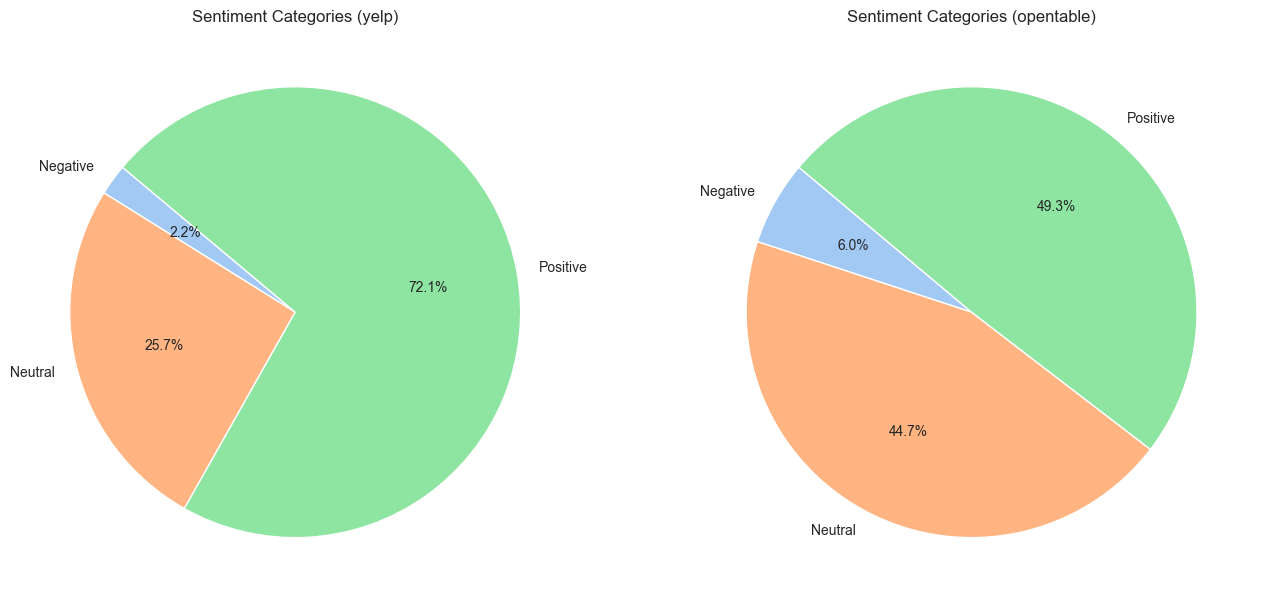

In [57]:
# Calculate proportions for each source
source_sentiment_counts = combined_reviews.groupby('source')['sentiment_category'].value_counts(normalize=True).unstack()

graph_per_row = 2
fig, axes = plt.subplots(math.ceil(num_of_sources / graph_per_row), graph_per_row, figsize=(16, 8))

colors = sns.color_palette("pastel")

# Pie for sources
for i, source in enumerate(processed_datasets):
    axes[i].pie(
        source_sentiment_counts.loc[source['name']],
        labels=source_sentiment_counts.loc[source['name']].index,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
    )
    axes[i].set_title(f"Sentiment Categories ({source['name']})")
    
plt.show()

A significant 72.1% of Yelp's reviews are positive, indicating that the majority of customers are satisfied with their experience at Italian restaurants in Rome, while only 49.3% of OpenTable's reviews are positive, showing a less dominant positive sentiment.

OpenTable has large proportion (44.7%) of reviews are neutral, suggesting that many customers in Paris had an average experience, while Yelp neutral reviews account for only 25.7%, indicating that reviews in Rome are less likely to be neutral and more polarized towards positive or negative.

Finally, for the negative sentiment, OpenTable's (Paris) 6% is relatively higher compared to Rome, which has only 2.2% of reviews are negative, showcasing a smaller percentage of dissatisfied customers.

# Conclusions

Italian Restaurants in Rome (Yelp) are perceived has overwhelmingly positive, with fewer neutral or negative reviews. This suggests a higher level of customer satisfaction overall.
Italian Restaurants in Paris (OpenTable) are more distributed between positive and neutral, with a slightly higher percentage of negative reviews. This indicates that while many customers had good experiences, a significant portion found their experience as average.